In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append('../src')
from rfm_analysis import RFMCalculator, CustomerSegmenter, visualize_clusters
from data_preprocessing import WoE_IV_Calculator 
from dataloader import DataLoader

sns.set_style("whitegrid")

In [2]:
DATA_PATH = '../data/data.csv'

# Load
loader = DataLoader(DATA_PATH)
df_raw = loader.load()
df_raw.head()

2025-12-16 18:55:11,793 - INFO - Data loaded successfully. Shape: (95662, 16)


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [3]:
df_features = pd.read_csv('../data/processed/customer_features.csv') # Unscaled version for merging
print(f"Features Loaded: {df_features.shape}")

Features Loaded: (3742, 24)


In [4]:
rfm_calc = RFMCalculator(df_raw)
df_rfm = rfm_calc.calculate_rfm(
    customer_col='CustomerId', 
    date_col='TransactionStartTime', 
    amount_col='Amount'
)

df_rfm.head()

📊 Calculating RFM Metrics...
✅ RFM Calculated. Shape: (3742, 3)


,Recency,Frequency,Monetary
CustomerId,,,
CustomerId_1,84,1,10000.0
CustomerId_10,84,1,10000.0
CustomerId_1001,90,5,20000.0
CustomerId_1002,26,11,4225.0
CustomerId_1003,12,6,20000.0


🧩 Segmenting customers into 3 clusters...
✅ Segmentation Complete.


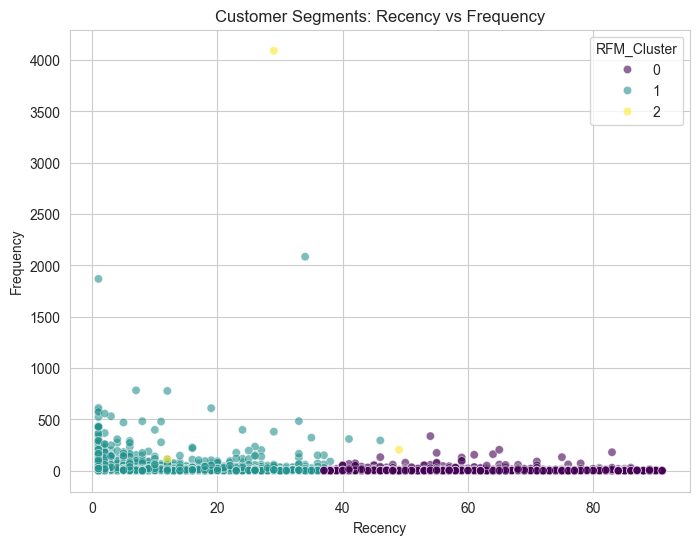

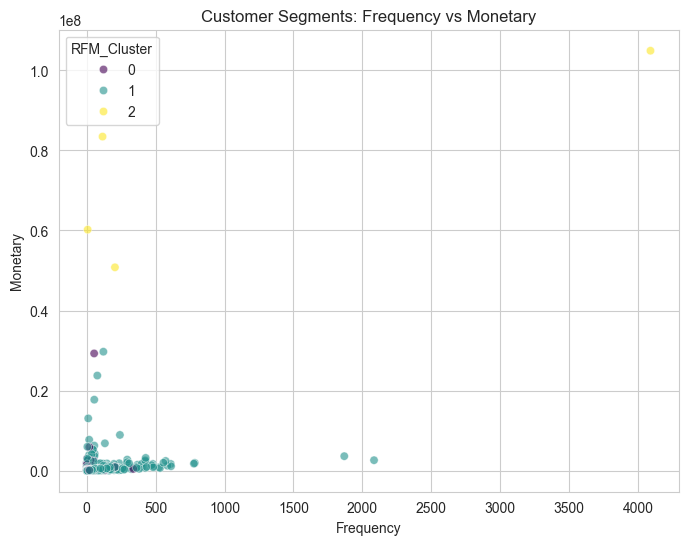

In [5]:
segmenter = CustomerSegmenter(df_rfm, n_clusters=3)
df_segmented = segmenter.segment()

# Visualize the segments
visualize_clusters(df_segmented, 'Recency', 'Frequency', 'RFM_Cluster')
visualize_clusters(df_segmented, 'Frequency', 'Monetary', 'RFM_Cluster')

In [6]:
df_labeled = segmenter.define_risk_label(df_segmented)

# Check distribution of Risk Label
print("\nRisk Distribution:")
print(df_labeled['is_high_risk'].value_counts(normalize=True))

df_labeled.head()


📊 Cluster Centroids (Averages):
               Recency    Frequency      Monetary
RFM_Cluster                                      
0            61.877279     7.720196  8.289085e+04
1            12.715398    34.703720  1.974840e+05
2            23.250000  1104.500000  7.484224e+07

⚠️ Identified Cluster 0 as 'High Risk' (Highest Recency).

Risk Distribution:
is_high_risk
0    0.61892
1    0.38108
Name: proportion, dtype: float64


,Recency,Frequency,Monetary,RFM_Cluster,is_high_risk
CustomerId,,,,,
CustomerId_1,84,1,10000.0,0,1
CustomerId_10,84,1,10000.0,0,1
CustomerId_1001,90,5,20000.0,0,1
CustomerId_1002,26,11,4225.0,1,0
CustomerId_1003,12,6,20000.0,1,0


In [7]:
df_labeled_reset = df_labeled.reset_index()

# 2. Merge on 'CustomerId' without using index flags
df_final = pd.merge(
    df_features, 
    df_labeled_reset[['CustomerId', 'is_high_risk']], 
    on='CustomerId', 
    how='inner'
)

# Now proceed with the rest of the validation
df_bin_check = df_final.copy()
df_bin_check['total_amount_bin'] = pd.qcut(df_bin_check['total_amount'], q=10, duplicates='drop')

# Calculate WoE
woe_calc = WoE_IV_Calculator(df_bin_check, 'total_amount_bin', 'is_high_risk')
woe_df = woe_calc.calculate()

print("Information Value for Total Amount:")
print(woe_df)
print(f"\nTotal IV: {woe_df['IV'].sum():.4f}")

Information Value for Total Amount:
                     Value  All  Good  Bad  Distr_Good  Distr_Bad       WoE  \
3          (950.0, 2000.0]  408   160  248    0.069085   0.173913 -0.922352   
7   (233658.3, 83451240.0]  375   309   66    0.133420   0.046283  1.057309   
6     (100282.8, 233658.3]  374   307   67    0.132556   0.046985  1.035815   
2         (2000.0, 6710.5]  338   146  192    0.063040   0.134642 -0.758014   
9      (60000.0, 100282.8]  352   274   78    0.118307   0.054698  0.770469   
0  (-104900000.001, 950.0]  377   173  204    0.074698   0.143058 -0.649158   
4       (38946.8, 60000.0]  396   299   97    0.129102   0.068022  0.640070   
8        (6710.5, 13976.0]  374   193  181    0.083333   0.126928 -0.420363   
1       (13976.0, 20000.0]  440   261  179    0.112694   0.125526 -0.107743   
5       (20000.0, 38946.8]  308   194  114    0.083765   0.079944  0.046634   

         IV  
3  0.096689  
7  0.092130  
6  0.088636  
2  0.054276  
9  0.049009  
0  0.04437

An Information Value (IV) of 0.4841 is generally considered to indicate a strong predictive power for a variable in a binary classification model

In [8]:
df_scaled = pd.read_csv('../data/processed/customer_features_scaled.csv')

# Merge only the target column (ensure ID alignment)
df_modeling = pd.merge(df_scaled, df_labeled[['is_high_risk']], on='CustomerId', how='inner')

In [9]:
output_path = '../data/processed/final_dataset_with_target.csv'
df_modeling.to_csv(output_path, index=False)

print(f"✅ Final Modeling Dataset Saved: {output_path}")
print(df_modeling.head())

✅ Final Modeling Dataset Saved: ../data/processed/final_dataset_with_target.csv
        CustomerId  total_amount  avg_amount  std_amount  txn_count  \
0     CustomerId_1     -0.066891   -0.153364   -0.140432  -0.253459   
1    CustomerId_10     -0.066891   -0.153364   -0.140432  -0.253459   
2  CustomerId_1001     -0.055849   -0.069870   -0.072731  -0.212186   
3  CustomerId_1002     -0.061655   -0.091435   -0.134647  -0.150278   
4  CustomerId_1003     -0.055849   -0.073846   -0.078186  -0.201868   

   Amount_min  Amount_max  Value_sum  Value_mean  avg_txn_hour  ...  \
0   -0.161532   -0.169081  -0.089524   -0.052297      0.883284  ...   
1   -0.161532   -0.169081  -0.089524   -0.052297      0.883284  ...   
2   -0.103274   -0.113497  -0.082011   -0.075710     -1.222654  ...   
3   -0.045890   -0.137120  -0.091448   -0.109431      0.229556  ...   
4   -0.103274   -0.113497  -0.081422   -0.080169      0.455248  ...   

   ProductCategory_other_ratio  ProductCategory_ticket_ratio  \
0 